## Explains, visualizes, and analyses the ePodium dataset.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import ipywidgets

import local_paths

from functions import epodium
from functions import dataset_loading
from functions import display_helper

### Loading EEG-data and metadata

Make sure *local_paths.ePod_dataset* contains the path to the __dataset__ and *local_paths.ePod_metadata* contains the __metadata__ files.

* *children.txt* contains the age and sex, and risk of dyslexia due to at least 1 dyslexic parents.
* *cdi.txt* contains aditional information about the child's vocabulary with the Communicative Development Inventories questionnaire
* *parents.txt* contains info on dyslexia tests and diagnoses of the parents.
* *CODES_overview* contains the mapping of event condition and stimulus to an event number.

In [2]:
dataset_raw, dataset_filenames = dataset_loading.load_dataset(local_paths.ePod_dataset, preload=False)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]
epod_children, epod_cdi, epod_parents, epod_codes = \
    dataset_loading.load_metadata(local_paths.ePod_metadata, epodium_metadata_filenames)

206 EEG files loaded


### Load events

The ePodium experiment is an *auditory oddball experiment*. Children listen to a sequence that contains __80% standard__ and __20% deviant__ syllables in order to elicit the *mismatch response*. 

For measurement 34 electrodes are used, of which __32 channels__ and 2 mastoid references. The measurement frequency is __2048.0 Hz__. 

Each test is around __30 minutes__, with sequences of around 7.5 minutes containing four different conditions:

+ Condition 1 __GiepMT__: standard "*giep*", deviant "*gip*": multiple pronounciations 
+ Condition 2 __GiepST__: standard "*giep*", deviant "*gip*": single pronounciation 
+ Condition 3 __GopMT__: standard "*gop*", deviant "*goep*": multiple pronounciations 
+ Condition 4 __GopST__: standard "*gop*", deviant "*goep*": single pronounciation


In [3]:
# Events are stored into .txt file for faster initialization
# Save events
n_events_stored = len(glob.glob(os.path.join(local_paths.ePod_events, '*.txt')))
if(n_events_stored == len(dataset_raw)):
    dataset_loading.save_events(local_paths.ePod_events, dataset_raw, dataset_filenames)

# Load events
events = dataset_loading.load_events(local_paths.ePod_events, dataset_filenames)

# Set multiple pronounciations as same event id to reduce the unique events from 78 to 12.
events_12 = epodium.group_events_12(events)

206 Event Marker files loaded


#### Choose which participant to analyse

In [4]:
participant = ipywidgets.Select(options=sorted(dataset_filenames), description='Participants:')
display(participant)

Select(description='Participants:', options=('101a', '101b', '102a', '102b', '103a', '103b', '104a', '104b', '…

#### Show part of the EEG signal

Opening raw-browser...


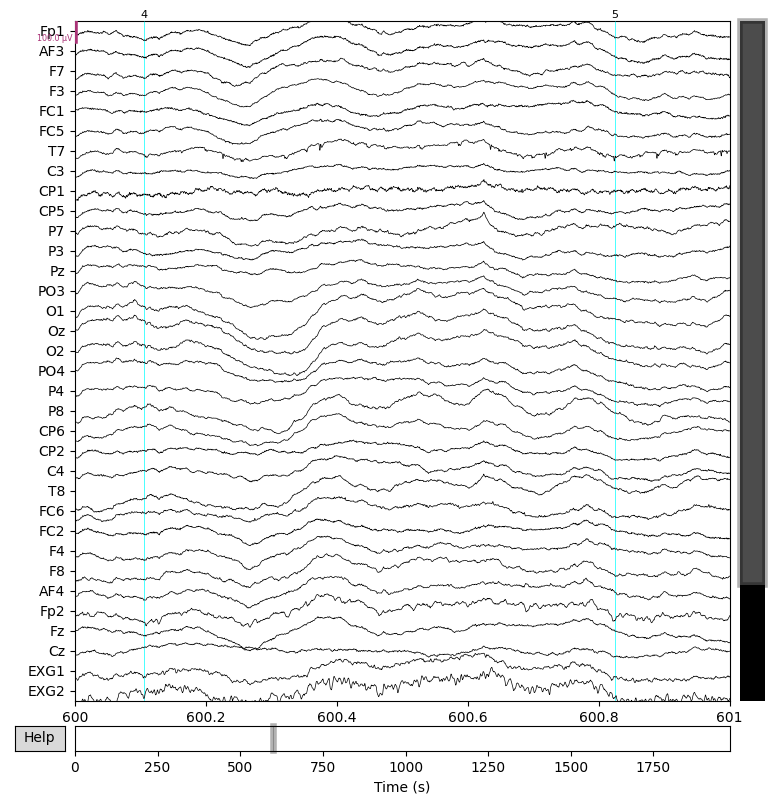

In [17]:
participant_raw = dataset_raw[dataset_filenames.index(participant.value)]
participant_events = events_12[dataset_filenames.index(participant.value)]

fig = mne.viz.plot_raw(participant_raw, participant_events, n_channels = 34, 
                       scalings = 50e-6, duration = 1, start = 600)

#### Plot events across time

The events are grouped into __12 event types__, 3 for each condition. 

Ideally, each condition has __120 deviants__ (D) and __360 standards__ (S).

The test also contains __first standards__ (FS) to make the child accustomed to the standard. First standards are discarded when calculating the mismatch response. 

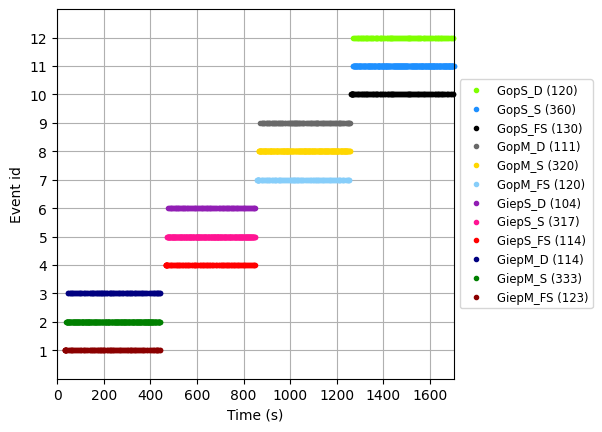

In [6]:
fig = mne.viz.plot_events(participant_events, event_id = epodium.event_dictionary, 
                          color = display_helper.color_dictionary, sfreq = 2048)

### Analyse event related potentials (ERPs)

The voltage change in the brain as a response to an event is called the *event-related potential* (ERP)

The response difference between a standard and deviant ERP is called the *mismatch response* (MMR).

The mismatch response can be analysed to predict differences between participants.


In [7]:
display(participant)

Select(description='Participants:', options=('101a', '101b', '102a', '102b', '103a', '103b', '104a', '104b', '…

#### Load processed data

In [11]:
path_npy = os.path.join(local_paths.ePod_processed_autoreject_epochs,  participant.value + ".npy")
path_events = os.path.join(local_paths.ePod_processed_autoreject_events, participant.value + ".txt")

epochs = epodium.load_processed_file(path_npy, path_events)

2440 different trials loaded 
Each trial contains 2049 timesteps in 32 channels.


#### Widget for plotting standard, deviant, and mismatch ERPs

In [12]:
condition = ipywidgets.RadioButtons(options=epodium.conditions, description='Condition:')
display(condition)
event_type = ipywidgets.RadioButtons(options=["standard", "deviant", "MMN"], description='Event type:', continuous_update=False,)
display(event_type)

RadioButtons(description='Condition:', options=('GiepM', 'GiepS', 'GopM', 'GopS'), value='GiepM')

RadioButtons(description='Event type:', options=('standard', 'deviant', 'MMN'), value='standard')

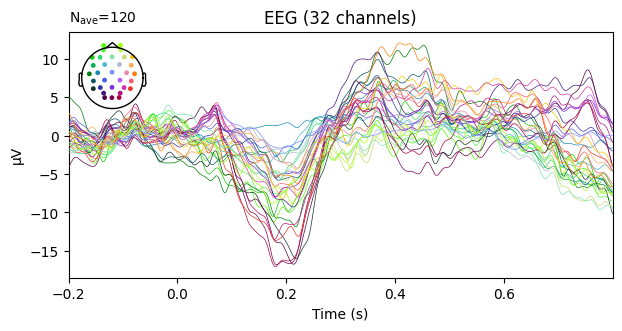

In [16]:
epodium.plot_ERP(epochs, condition.value, event_type.value)